<a href="https://colab.research.google.com/github/harrishmarro/Image_Processing_CNN/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip uninstall keras -y
# !pip uninstall keras-nightly -y
# !pip uninstall keras-Preprocessing -y
# !pip uninstall keras-vis -y
# !pip uninstall tensorflow -y

In [ ]:
# !pip install tensorflow
# !pip install keras==2.4

In [ ]:
!pip install keras==2.6.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.0 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.6.0 which is incompatible.


In [ ]:
import tensorflow as tf

In [ ]:
import os
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [ ]:
from PIL import Image

In [ ]:
import time

In [ ]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data_dir ='/content/drive/MyDrive/DATASET/train/' 
test_data_dir = '/content/drive/MyDrive/DATASET/test/'
val_data_dir = '/content/drive/MyDrive/DATASET/val/'

# train_data_dir = path+'/output/train'
# test_data_dir = path+'/output/test'
# val_data_dir = path+'/output/val'

class_subset = sorted(os.listdir("/content/drive/MyDrive/DATASET/val"))[:2]
class_subset

['guns', 'neutral']

In [ ]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(val_data_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                              target_size=(224, 224),
                                              class_mode=None,
                                              classes=class_subset,
                                              batch_size=1,
                                              shuffle=False,
                                              seed=42)

Found 863 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


In [ ]:
testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 93 images belonging to 2 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.35)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.005)
n_classes=2

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 15

In [ ]:
# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 19.1 MB/s 


In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/drive/MyDrive/MachineLearning_Traning/DATASET/tl_model_v1.weights.best1.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
# !pip install --upgrade tensorflow keras numpy pandas sklearn pillow

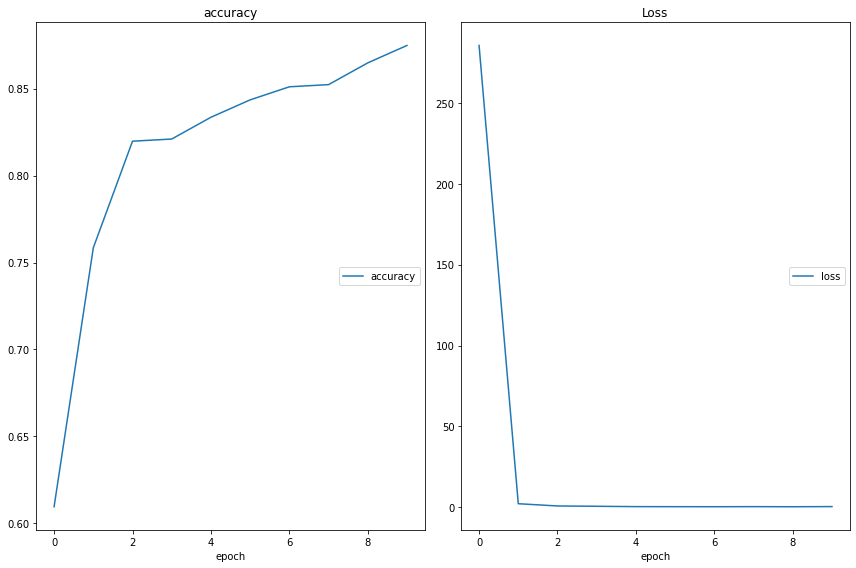

accuracy
	accuracy         	 (min:    0.610, max:    0.875, cur:    0.875)
Loss
	loss             	 (min:    0.341, max:  285.466, cur:    0.436)


In [ ]:
# %%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
#                             epochs=n_epochs,
                            epochs=10,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
from tensorflow import keras
vgg_model = keras.models.load_model('/content/drive/MyDrive/DATASET/tl_model_v1.weights.best.hdf5')

OSError: ignored

In [ ]:
img = tf.keras.utils.load_img('/content/drive/MyDrive/DATASET/test/guns/gn048.jpg', target_size=(224,224))
img1 = tf.keras.utils.load_img('/content/drive/MyDrive/DATASET/test/neutral/nt041.jpg', target_size=(224,224))

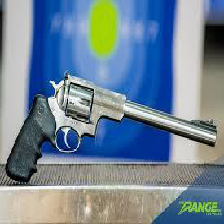

In [ ]:
img

In [ ]:
input_img = tf.keras.utils.img_to_array(img)
input_img = np.expand_dims(input_img, axis=0)

In [ ]:

predict_img = vgg_model.predict(input_img)
predict_img

array([[0.9582402 , 0.04175982]], dtype=float32)

In [ ]:
if predict_img[0][0] > predict_img[0][1]:
    print("guns")
else:
    print('neutral')

guns
